# Tutorial: Analyzing single cell calling cards collected from the mouse cortex

In this tutorial, we will analyze single cell calling data that describes Brd4 binding in the mouse cortex. The dataset comes from [Moudgil et al., Cell. (2020)](https://doi.org/10.1016/j.cell.2020.06.037) and can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148448).

In this tutorial, e will cover how to call peaks, annotatate them, perform a differential peak analysis, and pair peaks with genes. In this dataset, there are 111382 insertions and 35950 cells in total. However, many cells are filtered in scRNA-seq analysis. It uses Mudata for calling cards and RNA data. If you want to use Anndata only, please check [Github](https://nbviewer.org/github/The-Mitra-Lab/pycallingcards_data/blob/main/Mouse_cortex_Example_adata.ipynb)

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from mudata import MuData
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150

We start by reading the qbed datafile. In this file, each row represents a Brd4-directed insertion and columns indicate the chromosome, start point and end point, reads number, the direction and cell barcode of each insertion. For example, the first row indicates one transposition is located on Chromosome 1, and starts from 3112541 and ends on 3112545. The reads number is 12 with the direction going from 3' to 5'. The barcode of the cell is GATGAAAAGAGTTGGC-1. Note that the barcodes of cells should be consistent with scRNA-seq data.

Use ```cc.rd.read_qbed(filename)``` to read your own qbed data.

In [2]:
qbed_data = cc.datasets.mousecortex_data(data = "qbed")
qbed_data 

Chr     Start       End  Reads Direction            Barcodes
0       chr1   3112541   3112545     12         +  GATGAAAAGAGTTGGC-1
1       chr1   3121337   3121341      6         -  CGATCGGCACATTTCT-1
2       chr1   3199281   3199285      7         +  GTCCTCATCTCCGGTT-1
3       chr1   3211433   3211437     22         -  CGAGAAGAGGAATCGC-1
4       chr1   3245859   3245863    149         +  TTTACTGCATCCGCGA-1
...      ...       ...       ...    ...       ...                 ...
111377  chrY  90807968  90807972    200         -  ACGGAGAGTCGCATAT-1
111378  chrY  90833531  90833535     51         -  TAGCCGGTCCTGTACC-1
111379  chrY  90833600  90833604     13         -  TTGGCAAAGAATTGTG-1
111380  chrY  90840262  90840266      8         -  GTGCATAGTACCAGTT-1
111381  chrY  90840262  90840266     95         +  TTGTAGGTCGAATCCA-1

[111382 rows x 6 columns]

We next need to call peaks in order to find Brd4 binding sites. Three different methods (*CCcaller, cc_tools, Blockify*) are available along with three different species (*hg38, mm10, sacCer3*). 

In this setting, we will use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*. It controls the maximum distance between two nearby insertions, or, in another words, the minimum distance between two peaks. 800-2500 is a good parameter for *maxbetween*.  *pvalue_cutoff* is also an important parameter, and a number below 0.05 is strongly advised.

In [3]:
peak_data = cc.pp.call_peaks(qbed_data, method = "CCcaller", reference = "mm10",  maxbetween = 2000, 
                             pvalue_cutoff = 0.01, lam_win_size = 1000000,  pseudocounts = 1, record = True, 
                             save = 'mouse_cortex.bed')
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Chr      Start        End  Experiment Insertions  Reference Insertions  \
0    chr1    4806673    4809049                     12                    20   
1    chr1   14302176   14310895                     14                    92   
2    chr1   15287495   15288141                      8                     4   
3    chr1   18307949   18310271                      8                    31   
4    chr1   18976012   18982286                     13                    62   
..    ...        ...        ...                    ...                   ...   
696  chrX  158919208  158925514                      9                    39   
697  chrX  165325630  165327490                      8                    17   
698  chrX  166241178  166243587                      8                    18   
699  chrX  166345453  166350005                     11                    35   
700  chrX  169842873  169845831                      9                    28   

     Expected Insertions        pvalue    pvalue_adj  
0               1.120541  2.498336e-10  6.563055e-07  
1               1.523252  1.015569e-10  2.845105e-07  
2               1.029800  1.427167e-06  2.002598e-03  
3               1.151983  3.511291e-06  4.395841e-03  
4               1.452142  5.507813e-10  1.357847e-06  
..                   ...           ...           ...  
696             1.272189  9.683526e-07  1.413241e-03  
697             1.047701  1.640240e-06  2.254207e-03  
698             1.257844  7.050309e-06  8.151358e-03  
699             1.507674  7.204418e-08  1.263100e-04  
700             1.314399  1.292113e-06  1.842126e-03  

[701 rows x 8 columns]


In order to tune parameters for peak calling, we advise looking at the data and evaluating the validity of the called peaks. The default settings are recommended, but for some TFs, adjacent peaks may be merged that should not be, or, alternatively, peaks that should be joined may be called separately. 

In this plot, the top section is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The middle section is the distribution of insertions. The bottom section represents the reference genes and peaks. 

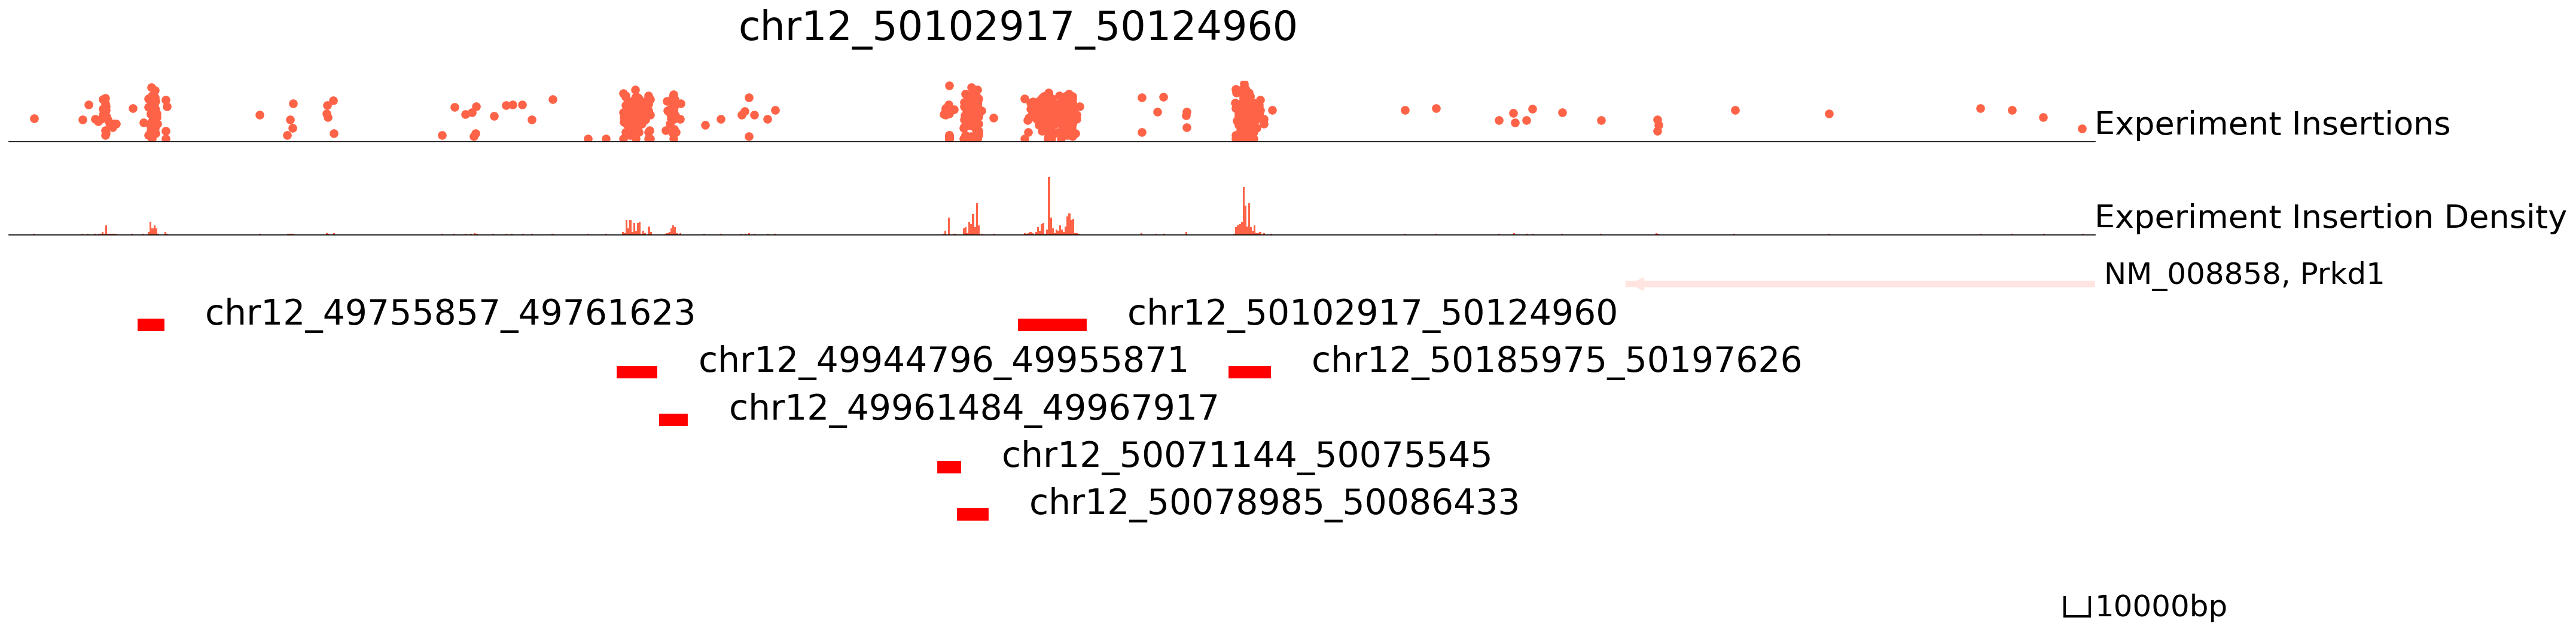

In [4]:
cc.pl.draw_area("chr12", 50102917, 50124960, 400000, peak_data, qbed_data, "mm10", font_size=2, plotsize = [1,1,6],
                figsize = (30,8), peak_line = 5, save = True, title = "chr12_50102917_50124960")

We can also visualize our data directly in the [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/). This can be useful for overlaying your data with other published datasets. Please note that this link only valid for 24hrs, so you will have to rerun it if you want to use it after this time period.

In [5]:
qbed = {"qbed_data":qbed_data}
bed = {"peak":peak_data}
cc.pl.WashU_browser_url(qbed = qbed, bed = bed, genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/69ce9f2d810a175f781fe054c320822b/output//datahub.json


Pycallingcards can be used to visual peak locations acorss the genome to see that the distribution of peaks is unbiased and that all chromosomes are represented.

In [6]:
cc.pl.whole_peaks(peak_data, reference = "mm10")

In the next step, we annotate the peaks by their closest genes using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure these programs are properly installed before using.

In [7]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data, peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


Chr      Start        End  Experiment Insertions  Reference Insertions  \
0    chr1    4806673    4809049                     12                    20   
1    chr1   14302176   14310895                     14                    92   
2    chr1   15287495   15288141                      8                     4   
3    chr1   18307949   18310271                      8                    31   
4    chr1   18976012   18982286                     13                    62   
..    ...        ...        ...                    ...                   ...   
696  chrX  158919208  158925514                      9                    39   
697  chrX  165325630  165327490                      8                    17   
698  chrX  166241178  166243587                      8                    18   
699  chrX  166345453  166350005                     11                    35   
700  chrX  169842873  169845831                      9                    28   

     Expected Insertions        pvalue    pvalue_adj Nearest Refseq1  \
0               1.120541  2.498336e-10  6.563055e-07       NM_008866   
1               1.523252  1.015569e-10  2.845105e-07       NM_010164   
2               1.029800  1.427167e-06  2.002598e-03    NM_001098528   
3               1.151983  3.511291e-06  4.395841e-03       NM_183124   
4               1.452142  5.507813e-10  1.357847e-06       NM_153154   
..                   ...           ...           ...             ...   
696             1.272189  9.683526e-07  1.413241e-03    NM_001346675   
697             1.047701  1.640240e-06  2.254207e-03       NM_183427   
698             1.257844  7.050309e-06  8.151358e-03       NM_023122   
699             1.507674  7.204418e-08  1.263100e-04       NM_023122   
700             1.314399  1.292113e-06  1.842126e-03       NM_010797   

    Gene Name1 Nearest Refseq2 Gene Name2  
0       Lypla1       NR_033530     Mrpl15  
1         Eya1       NM_010827        Msc  
2        Kcnb2       NM_177781      Trpa1  
3       Defb41    NM_001039123     Defb18  
4       Tfap2d    NM_001286340     Tfap2b  
..         ...             ...        ...  
696    Rps6ka3       NM_025437     Eif1ax  
697      Glra2       NM_175027      Fancb  
698      Gpm6b    NM_001310724     Gemin8  
699      Gpm6b       NM_177429       Ofd1  
700       Mid1    NM_001290506       Mid1  

[701 rows x 12 columns]

Then, we read the barcode file.

In [8]:
barcodes = cc.datasets.mousecortex_data(data = "barcodes")
barcodes

index
0      AAACCTGAGAACTCGG-1
1      AAACCTGAGCAATCTC-1
2      AAACCTGAGCCGTCGT-1
3      AAACCTGAGTAGCGGT-1
4      AAACCTGAGTGGAGTC-1
...                   ...
35945  TTTGTCAAGTCCCACG-1
35946  TTTGTCACAGCGTCCA-1
35947  TTTGTCACATTTCACT-1
35948  TTTGTCAGTCGCATCG-1
35949  TTTGTCATCTTTACAC-1

[35950 rows x 1 columns]

Use qbed data, peak data and barcode data to make a cell by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.

In [9]:
adata_cc = cc.pp.make_Anndata(qbed_data, peak_annotation, barcodes)
adata_cc

100%|██████████| 20/20 [00:00<00:00, 74.85it/s]


AnnData object with n_obs × n_vars = 35950 × 701
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In single cell calling cards, for each cell, RNA-seq data is collected simultaneously with TF binding information. For the following steps, we are going to read scRNA-seq data and analyze them together. [Scanpy](https://scanpy.readthedocs.io/en/stable/) is recommended to load and analyze scRNA-seq data.

In [10]:
adata = cc.datasets.mousecortex_data(data = "RNA")
adata

AnnData object with n_obs × n_vars = 30300 × 2638
    obs: 'batch', 'n_genes', 'total_counts', 'cluster'
    var: 'n_counts', 'n_cells', 'highly_variable'

In scRNA-seq analysis, many cells are filtered out because of low quality. We need to make the cells in qbed anndata to be the exactly same as RNA-seq anndata.

In [11]:
adata_cc = cc.pp.filter_adata_sc(adata_cc, adata)
adata_cc

View of AnnData object with n_obs × n_vars = 30300 × 701
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [12]:
mdata = MuData({"RNA": adata, "CC": adata_cc})
mdata

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


MuData object with n_obs × n_vars = 30300 × 3339
  2 modalities
    RNA:	30300 x 2638
      obs:	'batch', 'n_genes', 'total_counts', 'cluster'
      var:	'n_counts', 'n_cells', 'highly_variable'
    CC:	30300 x 701
      var:	'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Next, we will cluster cells by the RNA-seq data to identify cell types so that we can identify differentially bound peaks between different cell types.

Although one peak should have many insertions, but there is a chance that all the cells from the peak were filtered by the RNA preprocesssing. In this case, we advise to filter peaks by the minimum number of cells. 

In [13]:
cc.pp.filter_peaks(mdata["CC"], min_counts = 1)

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


Differential peak analysis shows significant bindings for each cluster. In this example, we use *binomial test* to find out.

In [14]:
cc.tl.rank_peak_groups_mu(mdata, "RNA:cluster", method = 'binomtest', key_added = 'binomtest')
mdata

100%|██████████| 18/18 [00:28<00:00,  1.57s/it]


MuData object with n_obs × n_vars = 30300 × 3339
  2 modalities
    RNA:	30300 x 2638
      obs:	'batch', 'n_genes', 'total_counts', 'cluster'
      var:	'n_counts', 'n_cells', 'highly_variable'
    CC:	30300 x 701
      var:	'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts'
      uns:	'binomtest'

Plot the results for differential peak analysis.

Currently, the peaks are ranked by pvalues. It could also be ranked by logfoldchanges by the following code:

```python
cc.tl.rank_peak_groups_mu(mdata, "RNA:cluster", method = 'binomtest', rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(mdata["CC"], key = 'binomtest', rankby = 'logfoldchanges')

```

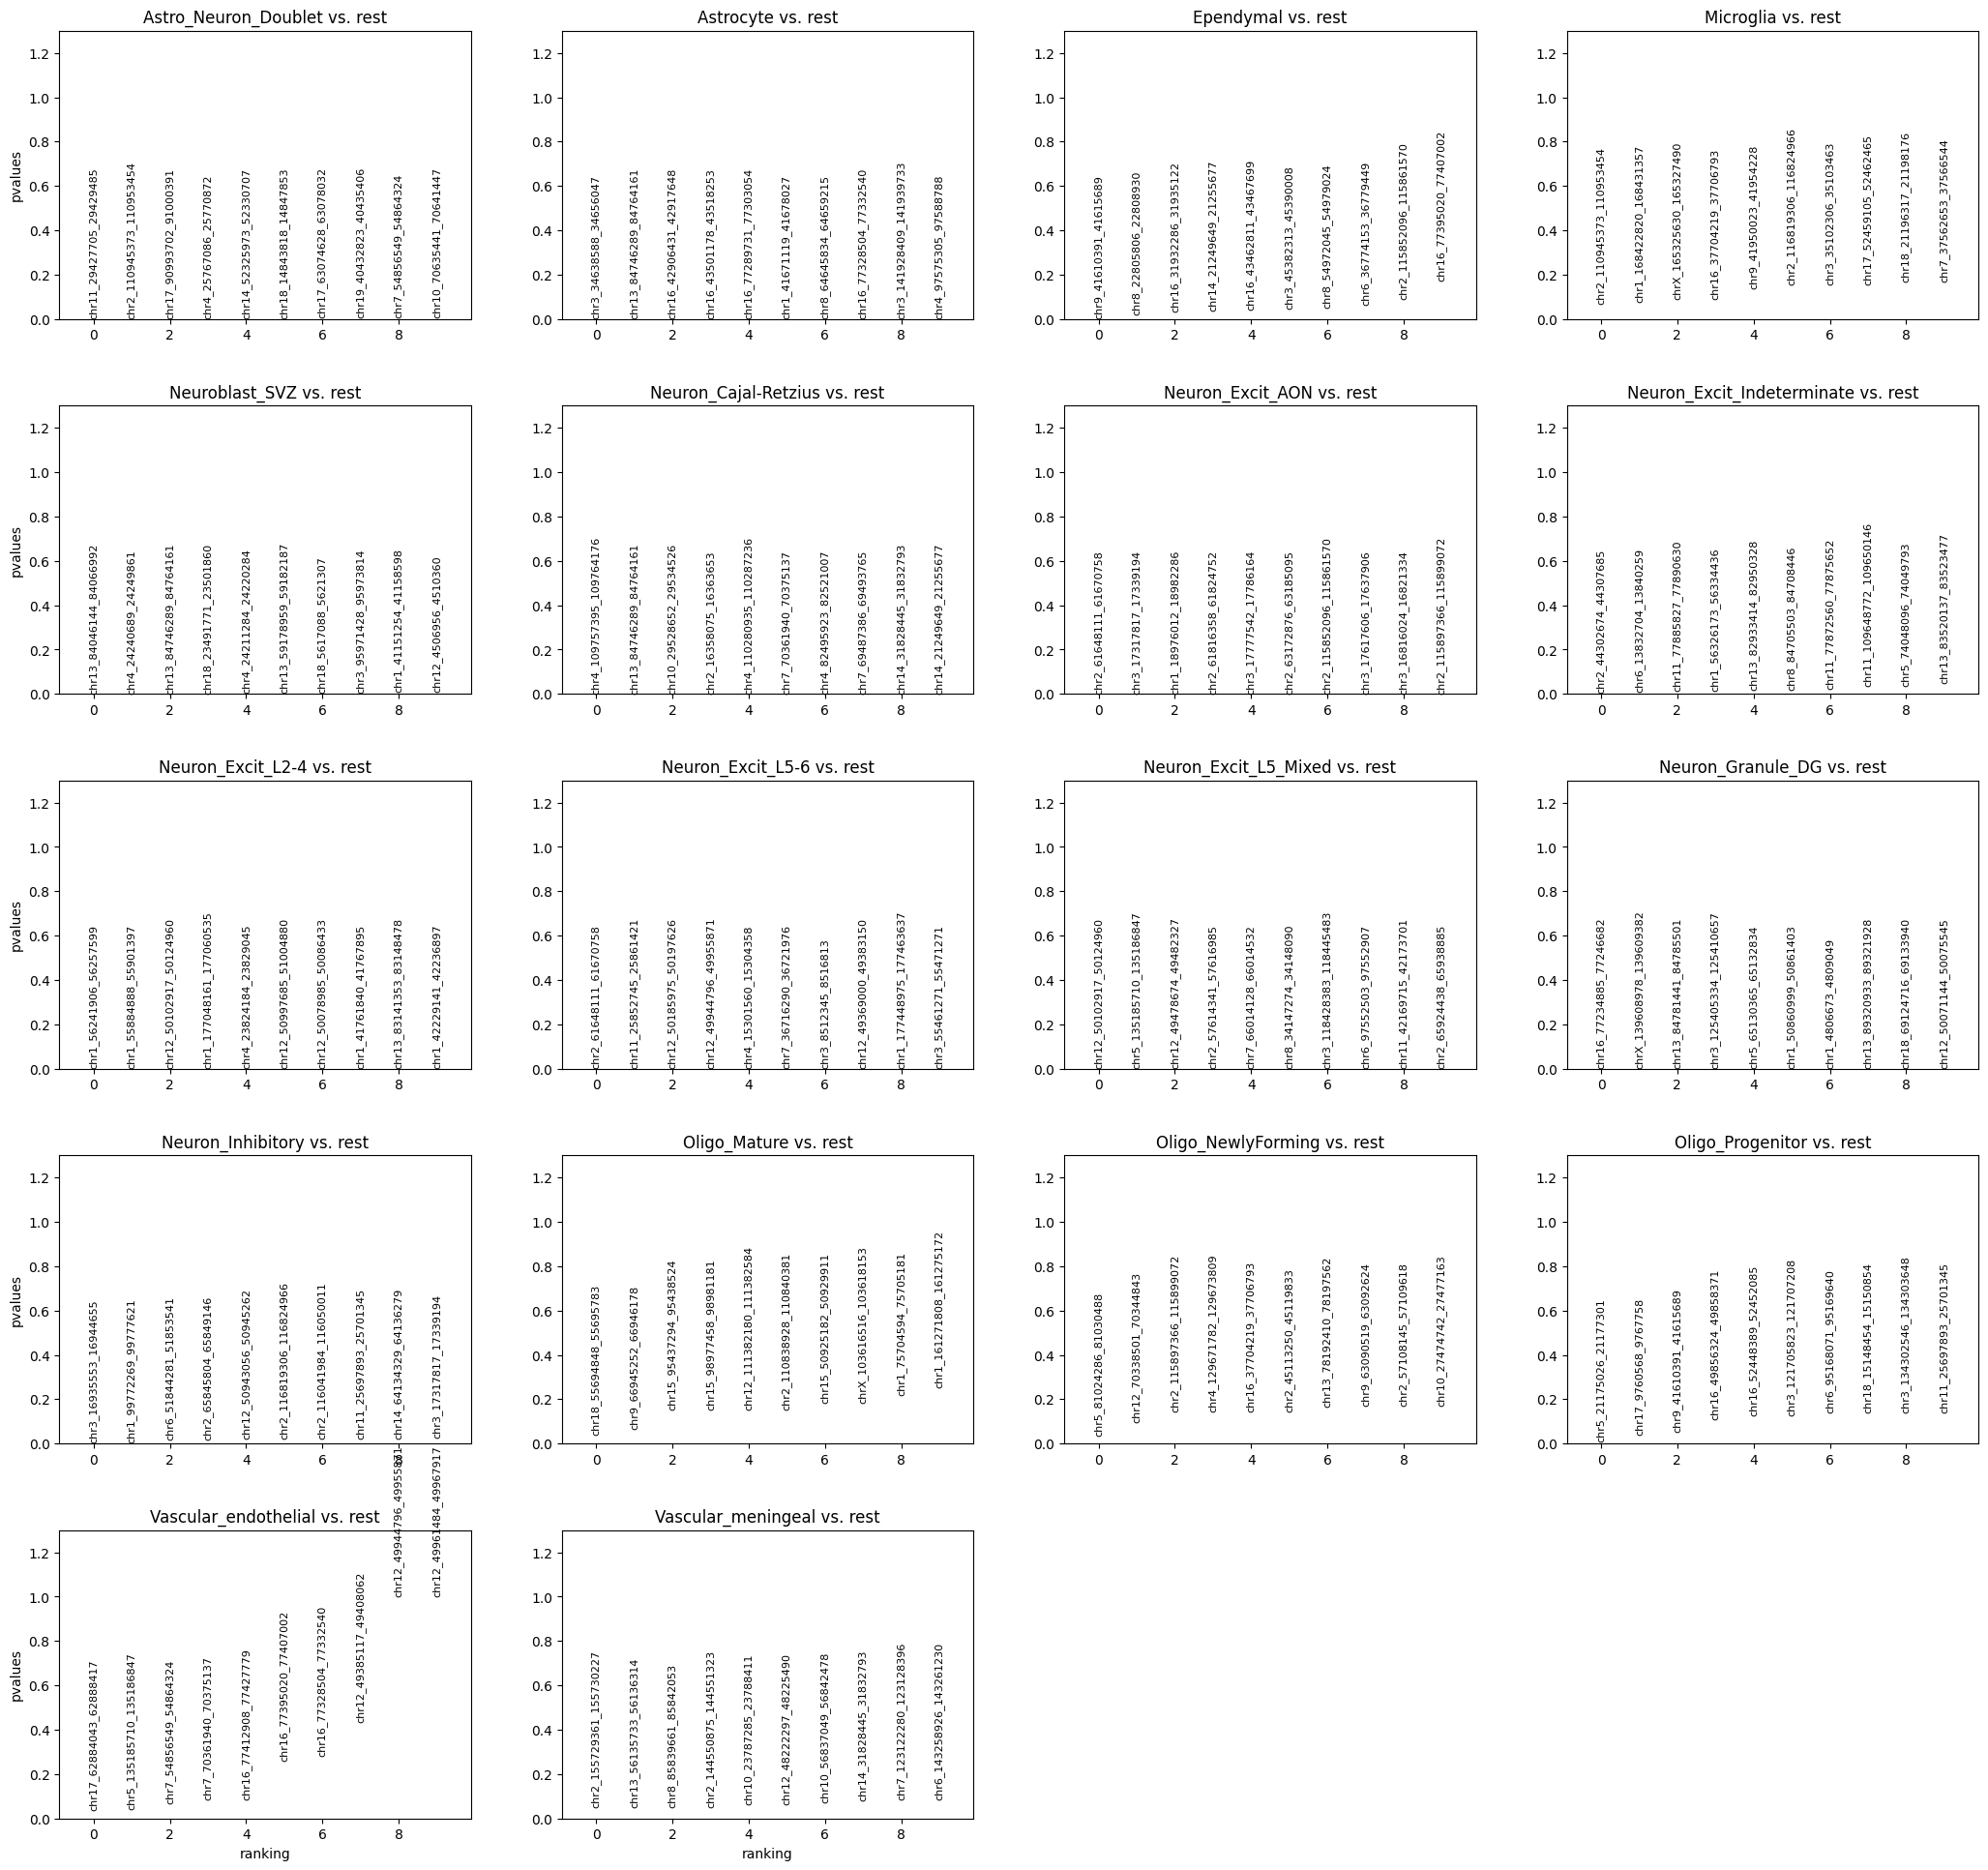

In [15]:
cc.pl.rank_peak_groups(mdata["CC"], key = 'binomtest', save = True)

Next, we will visualize differentially bound peaks. The colored datapoints are the insertions specific to a cluster and the grey ones are the total insertions across the rest of the clusters. We can see that most of the insertions are from Astrocyte in the following peaks.

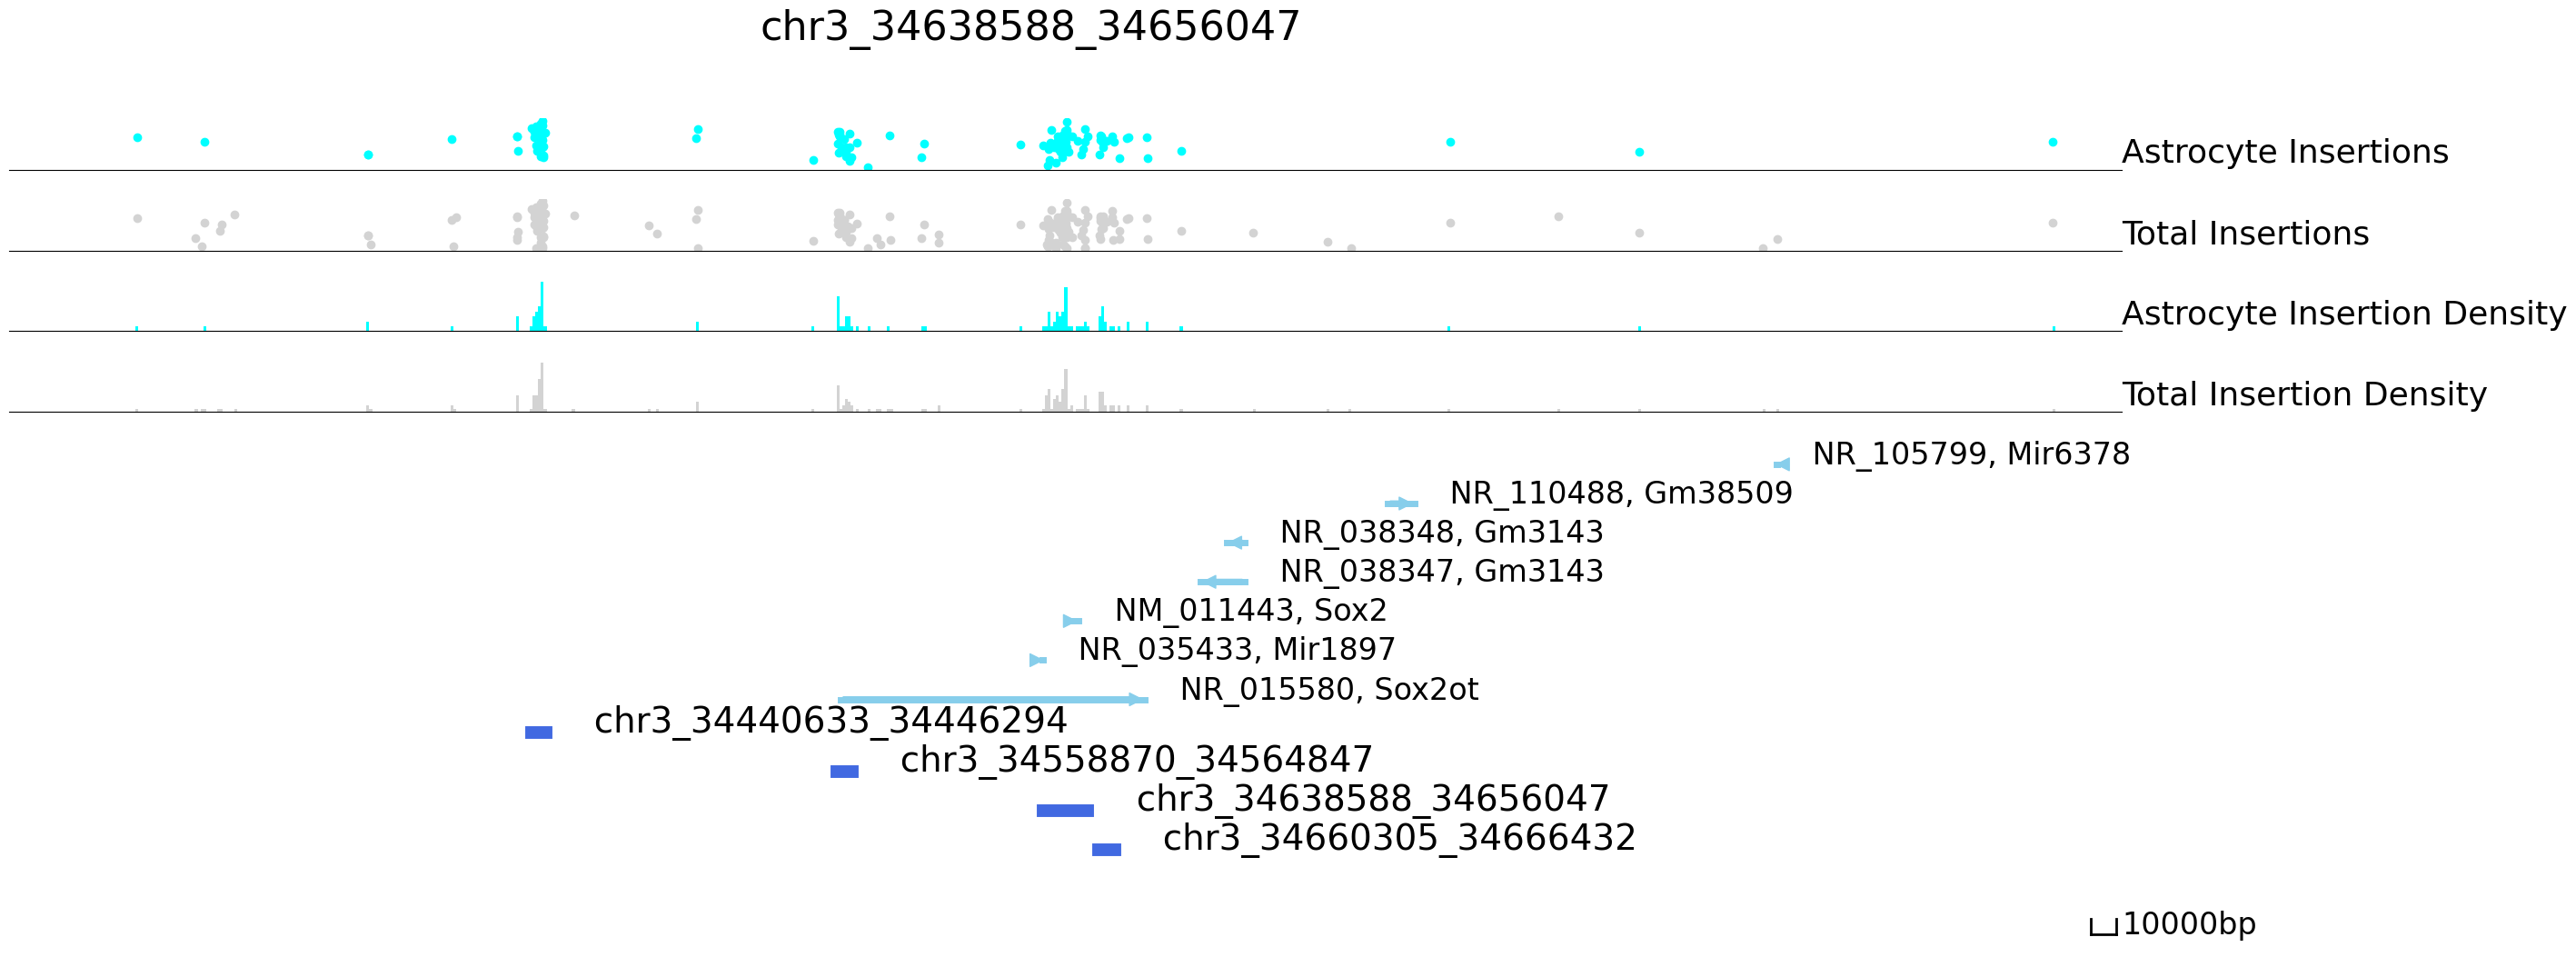

In [16]:
cc.pl.draw_area_mu("chr3", 34638588, 34656047, 400000, peak_data, qbed_data, "mm10", mdata = mdata, font_size = 2, 
                   name = 'Astrocyte', key = 'RNA:cluster', figsize = (30,12), peak_line = 4, color = "blue", 
                   name_insertion1 = 'Astrocyte Insertions', name_density1 = 'Astrocyte Insertion Density',
                   name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                   plotsize = [1,1,5], title = "chr3_34638588_34656047")

Next we can ask if differentially bound peaks are near differentially expressed genes, which might suggest the idenified enhancer regulates the nearby gene. 

We first perform a differential expression analysis for the scRNA-seq data.

In [17]:
sc.tl.rank_genes_groups(mdata["RNA"], 'cluster')

Next, we find peak-gene pairs that are differentially bound/regulated in the specified cell-type. We look at all differential peaks in each cluster and see if the annotated genes are significantly expressed in the cluster. We can then set the pvalue and score/log foldchange cutoff.


In [18]:
cc.tl.pair_peak_gene_sc_mu(mdata, pvalue_adj_cutoff_cc = 0.05, pvalue_adj_cutoff_rna = 0.05, 
                           lfc_cutoff = 3, score_cutoff = 3)
mdata["CC"].uns['pair']

Cluster                      Peak  Logfoldchanges  \
0               Astrocyte   chr16_43501178_43518253        3.077262   
1               Astrocyte    chr8_64645834_64659215        4.623955   
2               Astrocyte  chr3_141928409_141939733        4.876938   
3               Astrocyte    chr4_97575305_97588788        3.099679   
4               Astrocyte    chr4_97575305_97588788        3.099679   
..                    ...                       ...             ...   
57      Neuron_Excit_L2-4   chr13_83141353_83148478        3.495487   
58  Neuron_Excit_L5_Mixed    chr7_66014128_66014532        3.737143   
59      Neuron_Granule_DG  chr3_125405334_125410657        5.806064   
60      Neuron_Granule_DG  chr3_125405334_125410657        5.806064   
61      Neuron_Granule_DG    chr1_50860999_50861403        4.356917   

     Pvalue_peak  Pvalue_adj_peak           Gene  Score_gene    Pvalue_gene  \
0   1.462410e-16     2.562874e-14         Zbtb20   79.234276   0.000000e+00   
1   3.114365e-14     2.949104e-12          Msmo1   61.964111   0.000000e+00   
2   3.786296e-14     2.949104e-12         Bmpr1b   24.131538  2.475603e-121   
3   5.907086e-14     4.140867e-12  E130114P18Rik   16.893749   3.380841e-62   
4   5.907086e-14     4.140867e-12           Nfia   45.417362   0.000000e+00   
..           ...              ...            ...         ...            ...   
57  3.141216e-06     2.446659e-04          Mef2c  182.292236   0.000000e+00   
58  2.786909e-04     2.858012e-02          Pcsk6  -16.587570   2.263189e-61   
59  1.011677e-04     1.251507e-02          Ndst4    4.497158   8.449939e-06   
60  1.011677e-04     1.251507e-02          Ugt8a  -23.040115   5.201659e-89   
61  1.071190e-04     1.251507e-02         Tmeff2    3.399986   7.231398e-04   

    Pvalue_adj_gene  
0      0.000000e+00  
1      0.000000e+00  
2     1.659753e-120  
3      1.514206e-61  
4      0.000000e+00  
..              ...  
57     0.000000e+00  
58     3.313281e-60  
59     3.032315e-05  
60     3.379286e-87  
61     1.952972e-03  

[62 rows x 9 columns]

Plot the results above to find out the potential relationship between TF bindings and gene expression.

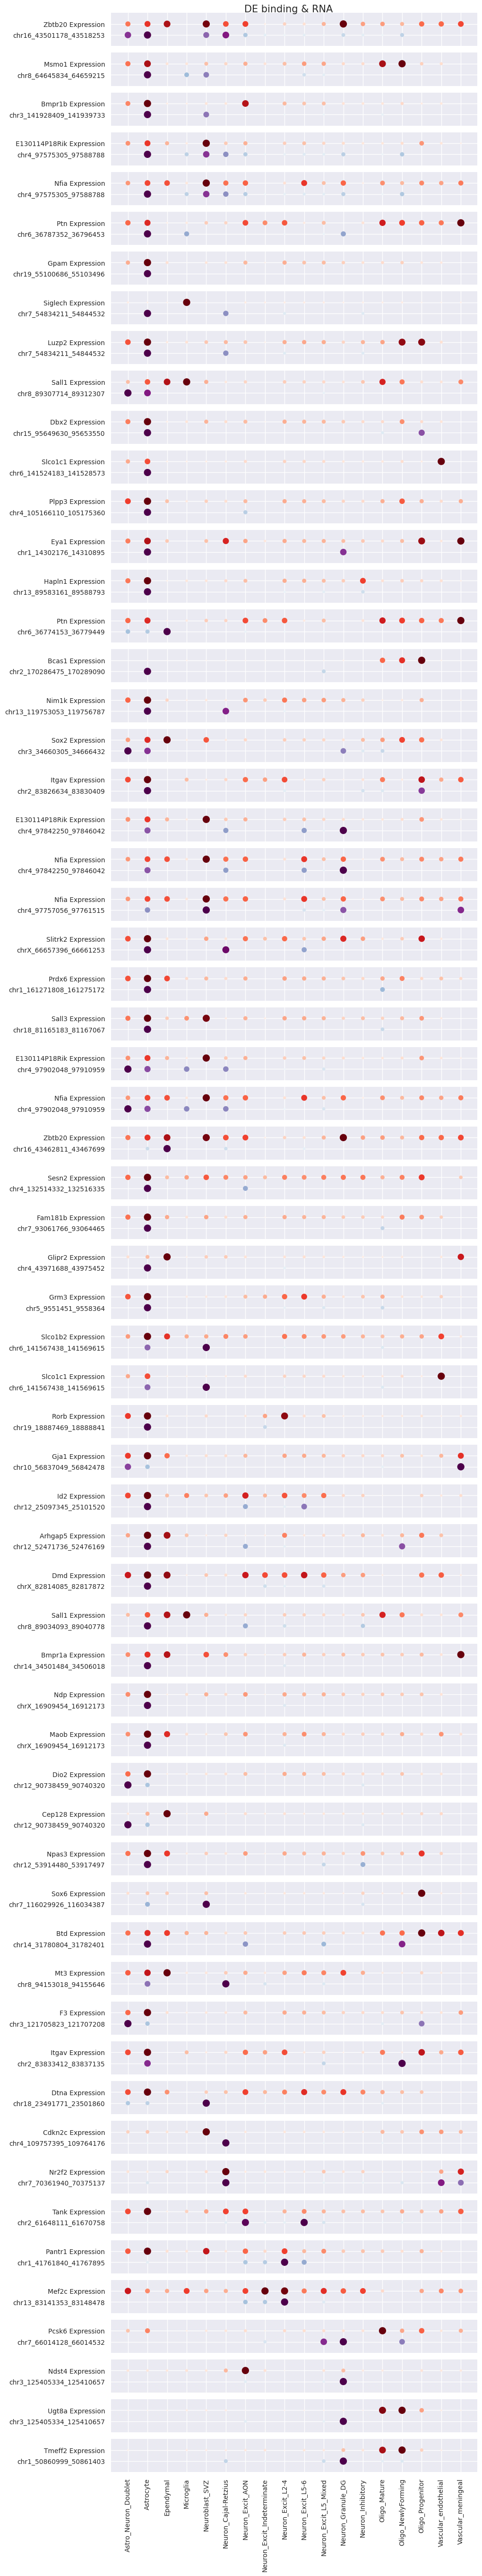

In [19]:
cc.pl.dotplot_sc_mu(mdata, figsize=(10, 60))

After seeing the dotplot above, bring some peaks to the RNA Anndata object and see the distribution in the UMAP plot.

In [20]:
sc.pp.pca(mdata["RNA"])
sc.pp.neighbors(mdata["RNA"])
sc.tl.umap(mdata["RNA"])

The first plot is the average insertions of the peak in each cluster, the second plot is the gene expression Gou3f2 (one of its nearest genes for the peak); the third plot is the cluster information.

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


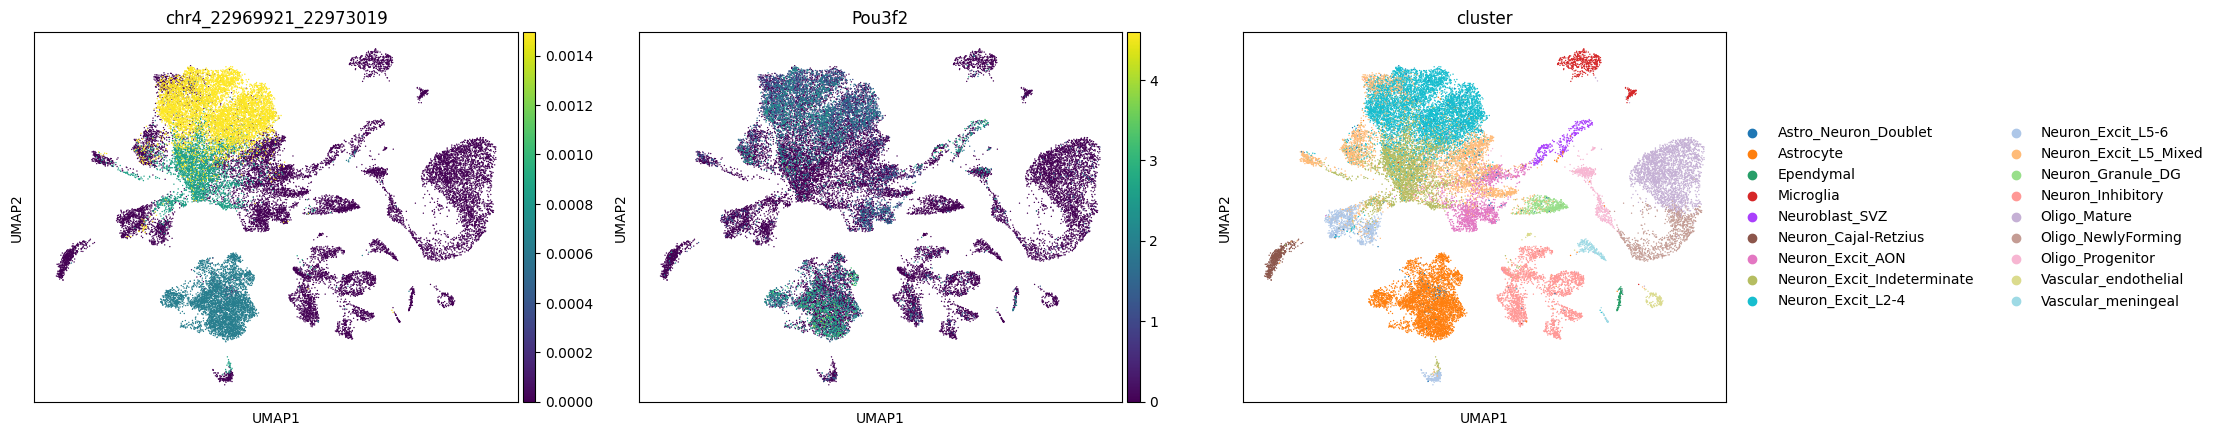

In [21]:
cc.pl.plot_matched(mdata, 'chr4_22969921_22973019', 'Pou3f2')

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


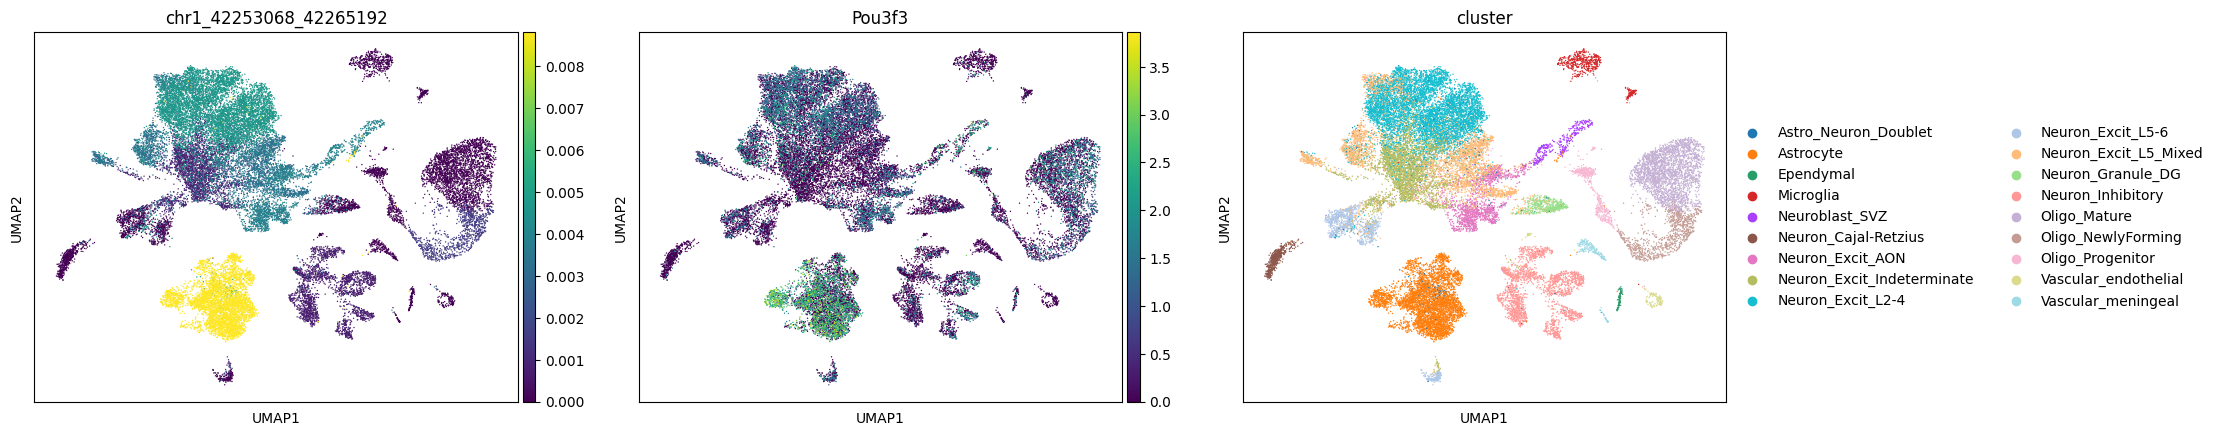

In [22]:
cc.pl.plot_matched(mdata, 'chr1_42253068_42265192', 'Pou3f3')

We can see a potential relationship between Brd4 binding and gene expression.

If we map these enhancers to the human genome, are there disease associated SNPs nearby?  To answer this question, we can map binding sites and genes to the human genome. We use [liftover](https://genome.ucsc.edu/cgi-bin/hgLiftOver) to get the resuls.

In [23]:
mdata["CC"].uns["pair"] = cc.tl.result_mapping(mdata["CC"].uns["pair"])
mdata["CC"].uns["pair"]

Start mapping the peaks to the new genome.


100%|██████████| 62/62 [00:00<00:00, 180.00it/s]


Start finding location of genes in the new genome.


100%|██████████| 62/62 [00:00<00:00, 209.47it/s]


Cluster                      Peak  Logfoldchanges  \
0               Astrocyte   chr16_43501178_43518253        3.077262   
1               Astrocyte    chr8_64645834_64659215        4.623955   
2               Astrocyte  chr3_141928409_141939733        4.876938   
3               Astrocyte    chr4_97575305_97588788        3.099679   
4               Astrocyte    chr4_97575305_97588788        3.099679   
..                    ...                       ...             ...   
57      Neuron_Excit_L2-4   chr13_83141353_83148478        3.495487   
58  Neuron_Excit_L5_Mixed    chr7_66014128_66014532        3.737143   
59      Neuron_Granule_DG  chr3_125405334_125410657        5.806064   
60      Neuron_Granule_DG  chr3_125405334_125410657        5.806064   
61      Neuron_Granule_DG    chr1_50860999_50861403        4.356917   

     Pvalue_peak  Pvalue_adj_peak           Gene  Score_gene    Pvalue_gene  \
0   1.462410e-16     2.562874e-14         Zbtb20   79.234276   0.000000e+00   
1   3.114365e-14     2.949104e-12          Msmo1   61.964111   0.000000e+00   
2   3.786296e-14     2.949104e-12         Bmpr1b   24.131538  2.475603e-121   
3   5.907086e-14     4.140867e-12  E130114P18Rik   16.893749   3.380841e-62   
4   5.907086e-14     4.140867e-12           Nfia   45.417362   0.000000e+00   
..           ...              ...            ...         ...            ...   
57  3.141216e-06     2.446659e-04          Mef2c  182.292236   0.000000e+00   
58  2.786909e-04     2.858012e-02          Pcsk6  -16.587570   2.263189e-61   
59  1.011677e-04     1.251507e-02          Ndst4    4.497158   8.449939e-06   
60  1.011677e-04     1.251507e-02          Ugt8a  -23.040115   5.201659e-89   
61  1.071190e-04     1.251507e-02         Tmeff2    3.399986   7.231398e-04   

    Pvalue_adj_gene Chr_liftover Start_liftover End_liftover Chr_hg38  \
0      0.000000e+00         chr3      114439800    114457200     chr3   
1      0.000000e+00         chr4      165418445    165438029     chr4   
2     1.659753e-120         chr4       95040417     95054959     chr4   
3      1.514206e-61         chr1       60858298     60872361            
4      0.000000e+00         chr1       60858298     60872361     chr1   
..              ...          ...            ...          ...      ...   
57     0.000000e+00         chr5       89235156     89249323     chr5   
58     3.313281e-60        chr15      101337048    101337565    chr15   
59     3.032315e-05         chr4      115106106    115112630     chr4   
60     3.379286e-87         chr4      115106106    115112630            
61     1.952972e-03                                              chr2   

   Start_hg38   End_hg38  
0   114314499  115147280  
1   165327665  165343162  
2    94757976   95158450  
3                         
4    61077273   61462788  
..        ...        ...  
57   88718240   88904105  
58  101303927  101489984  
59  114827772  115113876  
60                        
61  191949045  192194933  

[62 rows x 15 columns]

We search the [GWAS Catalog database](https://www.ebi.ac.uk/gwas/docs/file-downloads) and find out related SNPs in the binding areas.

In [24]:
mdata["CC"].uns["pair"] = cc.tl.GWAS(mdata["CC"].uns["pair"])
mdata["CC"].uns["pair"]

Cluster                      Peak  Logfoldchanges  \
0               Astrocyte   chr16_43501178_43518253        3.077262   
1               Astrocyte    chr8_64645834_64659215        4.623955   
2               Astrocyte  chr3_141928409_141939733        4.876938   
3               Astrocyte    chr4_97575305_97588788        3.099679   
4               Astrocyte    chr4_97575305_97588788        3.099679   
..                    ...                       ...             ...   
57      Neuron_Excit_L2-4   chr13_83141353_83148478        3.495487   
58  Neuron_Excit_L5_Mixed    chr7_66014128_66014532        3.737143   
59      Neuron_Granule_DG  chr3_125405334_125410657        5.806064   
60      Neuron_Granule_DG  chr3_125405334_125410657        5.806064   
61      Neuron_Granule_DG    chr1_50860999_50861403        4.356917   

     Pvalue_peak  Pvalue_adj_peak           Gene  Score_gene    Pvalue_gene  \
0   1.462410e-16     2.562874e-14         Zbtb20   79.234276   0.000000e+00   
1   3.114365e-14     2.949104e-12          Msmo1   61.964111   0.000000e+00   
2   3.786296e-14     2.949104e-12         Bmpr1b   24.131538  2.475603e-121   
3   5.907086e-14     4.140867e-12  E130114P18Rik   16.893749   3.380841e-62   
4   5.907086e-14     4.140867e-12           Nfia   45.417362   0.000000e+00   
..           ...              ...            ...         ...            ...   
57  3.141216e-06     2.446659e-04          Mef2c  182.292236   0.000000e+00   
58  2.786909e-04     2.858012e-02          Pcsk6  -16.587570   2.263189e-61   
59  1.011677e-04     1.251507e-02          Ndst4    4.497158   8.449939e-06   
60  1.011677e-04     1.251507e-02          Ugt8a  -23.040115   5.201659e-89   
61  1.071190e-04     1.251507e-02         Tmeff2    3.399986   7.231398e-04   

    Pvalue_adj_gene Chr_liftover Start_liftover End_liftover Chr_hg38  \
0      0.000000e+00         chr3      114439800    114457200     chr3   
1      0.000000e+00         chr4      165418445    165438029     chr4   
2     1.659753e-120         chr4       95040417     95054959     chr4   
3      1.514206e-61         chr1       60858298     60872361            
4      0.000000e+00         chr1       60858298     60872361     chr1   
..              ...          ...            ...          ...      ...   
57     0.000000e+00         chr5       89235156     89249323     chr5   
58     3.313281e-60        chr15      101337048    101337565    chr15   
59     3.032315e-05         chr4      115106106    115112630     chr4   
60     3.379286e-87         chr4      115106106    115112630            
61     1.952972e-03                                              chr2   

   Start_hg38   End_hg38                                               GWAS  
0   114314499  115147280  Schizophrenia; Smoking status (ever vs never s...  
1   165327665  165343162             Atopic dermatitis (moderate to severe)  
2    94757976   95158450                                                     
3                                                          Refractive error  
4    61077273   61462788                                   Refractive error  
..        ...        ...                                                ...  
57   88718240   88904105  Macular thickness; Waist circumference adjuste...  
58  101303927  101489984                                                     
59  114827772  115113876                                                     
60                                                                           
61  191949045  192194933                                                     

[62 rows x 16 columns]

Save the file if needed.

In [25]:
mdata.write("Mouse-Cortex.h5mu")

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
